In [79]:
import sqlite3
import pandas as pd
import seaborn as sns
import math
from datetime import datetime
import plotly.express as px

In [80]:


# Connect to the SQLite database
conn = sqlite3.connect(r'data/caltrain_lat_long.db')

# Query the database and load the results into a pandas DataFrame
query = """
SELECT *
FROM train_locations
"""
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

In [81]:
df['stop_id'] = df['stop_id'].astype(int)

df['trip_id'] = df['trip_id'].astype(int)

In [82]:
def load_stops_data():
    stops_df = pd.read_csv('gtfs_data/stops.txt')
    stops_df = stops_df[stops_df['stop_id'].str.isnumeric()]
    return stops_df
def load_stop_times_data():
    stop_times_df = pd.read_csv('gtfs_data/stop_times.txt')
    return stop_times_df
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000  # Radius of Earth in meters
    return r * c

def has_train_arrived(train_lat, train_lon, stop_lat, stop_lon, threshold=100):
    distance = haversine(train_lat, train_lon, stop_lat, stop_lon)
    return distance <= threshold

In [83]:
stops_df = load_stops_data()
stop_times_df = load_stop_times_data()
stops_df['stop_id'] = stops_df['stop_id'].astype(int)

In [84]:
stops_df=stops_df.sort_values(by='stop_id')
stops_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,stop_desc,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,platform_code
78,70011,70011,San Francisco Caltrain Station Northbound,37.776390,-122.394992,74634,NaN,NaN,0,san_francisco,NaN,1,NaN
79,70012,70012,San Francisco Caltrain Station Southbound,37.776348,-122.394935,74634,NaN,NaN,0,san_francisco,NaN,1,NaN
1,70021,70021,22nd Street Caltrain Station Northbound,37.757599,-122.391880,74634,NaN,NaN,0,22nd_street,NaN,2,NaN
2,70022,70022,22nd Street Caltrain Station Southbound,37.757583,-122.392404,74634,NaN,NaN,0,22nd_street,NaN,2,NaN
4,70031,70031,Bayshore Caltrain Station Northbound,37.709537,-122.401586,74634,NaN,NaN,0,bayshore,NaN,1,NaN


In [85]:
df2 = pd.merge(df,stop_times_df[['trip_id','stop_id','arrival_time']],on=['trip_id','stop_id'])
df2 = pd.merge(df2,stops_df[['stop_id','stop_name','parent_station','stop_lat','stop_lon']],on=['stop_id'])

In [86]:
# Apply the Haversine function to calculate distance for each row
df2['distance'] = df2.apply(lambda row: haversine(row['vehicle_lat'], row['vehicle_lon'], row['stop_lat'], row['stop_lon']), axis=1)


In [87]:
df2['timestamp']=pd.to_datetime(df2['timestamp'])
df2['date'] = df2['timestamp'].dt.date

In [88]:
def normalize_time(t):
    if int(t.split(":")[0]) >= 24:
        return "00" + t[2:]
    return t
# Normalize the arrival times


In [89]:
import pandas as pd
from datetime import datetime, time, timedelta


# Normalize the arrival times
def normalize_time(t):
    if int(t.split(":")[0]) >= 24:
        return "00" + t[2:]
    return t

df2['arrival_time'] = df2['arrival_time'].apply(normalize_time)

# Convert 'timestamp' to datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2['arrival_time'] = pd.to_datetime(df2['arrival_time'], format='%H:%M:%S').dt.time

# Function to calculate time difference in minutes
def calculate_time_difference(time1, time2):
    datetime1 = datetime.combine(datetime.today(), time1)
    datetime2 = datetime.combine(datetime.today(), time2)
    time_diff = datetime2 - datetime1
    return time_diff.total_seconds() / 60  # Return the difference in minutes

# Find the minimum distance for each combination of trip_id, stop_id, and date
min_distances = df2.groupby(['trip_id', 'stop_id', 'date'])['distance'].min().reset_index()

# Merge the minimum distances back to the original dataframe
merged_df = pd.merge(df2, min_distances, on=['trip_id', 'stop_id', 'date', 'distance'])

arrival_times = merged_df.groupby(['trip_id', 'stop_id', 'date']).first().reset_index()
arrival_times = arrival_times[['trip_id', 'stop_id', 'date', 'timestamp']]
arrival_times.rename(columns={'timestamp': 'actual_arrival_time'}, inplace=True)

# Merge with the original dataframe to get the scheduled arrival time
comparison_df = pd.merge(arrival_times, df2[['trip_id', 'stop_id', 'stop_name','parent_station','date', 'arrival_time']], on=['trip_id', 'stop_id', 'date'])

# Calculate the delay in minutes
comparison_df['delay_minutes'] = comparison_df.apply(
    lambda row: calculate_time_difference( row['arrival_time'],row['actual_arrival_time'].time(),), axis=1
)
comparison_df.loc[comparison_df.delay_minutes > 500,'delay_minutes'] = 0.0
comparison_df.loc[comparison_df.delay_minutes < -100,'delay_minutes'] = 0.0
# Determine if the train is delayed
comparison_df['is_delayed'] = comparison_df['delay_minutes'] > 4

# Calculate the overall on-time performance based on unique trip counts
unique_trips = comparison_df.drop_duplicates(subset=['trip_id', 'stop_id', 'date'])
total_trips = len(unique_trips)
on_time_trips = len(unique_trips[unique_trips['is_delayed'] == False])
on_time_performance = (on_time_trips / total_trips) * 100

# print(comparison_df)
print(f"Total unique trips: {total_trips}")
print(f"On-time trips: {on_time_trips}")
print(f"On-time performance: {on_time_performance:.2f}%")


Total unique trips: 8469
On-time trips: 7082
On-time performance: 83.62%


In [90]:
df2['arrival_time']

0        15:52:00
1        15:50:00
2        16:03:00
3        17:05:00
4        15:52:00
           ...   
65931    19:35:00
65932    19:36:00
65933    19:41:00
65934    19:38:00
65935    20:11:00
Name: arrival_time, Length: 65936, dtype: object

In [91]:
df2.timestamp

0       2024-07-07 15:48:54
1       2024-07-07 15:48:54
2       2024-07-07 15:48:54
3       2024-07-07 15:48:54
4       2024-07-07 15:49:54
                ...        
65931   2024-07-16 19:36:40
65932   2024-07-16 19:36:40
65933   2024-07-16 19:36:40
65934   2024-07-16 19:36:40
65935   2024-07-16 19:36:40
Name: timestamp, Length: 65936, dtype: datetime64[ns]

<Axes: xlabel='delay_minutes', ylabel='Count'>

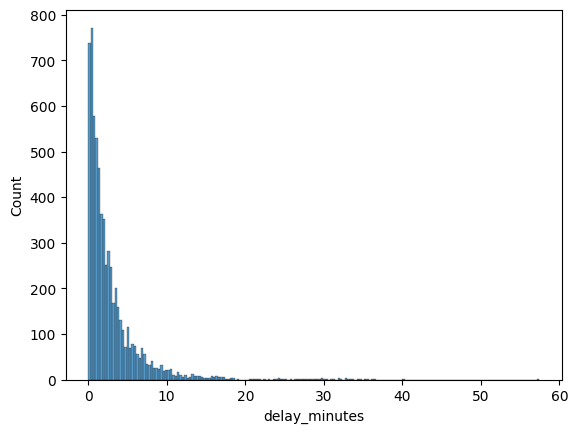

In [92]:
sns.histplot(data=unique_trips.loc[unique_trips.delay_minutes >=0],x='delay_minutes')

In [93]:
# test=df2.loc[(df2.date == datetime(2024, 7, 16).date()) & (df2.trip_id==306)]
# # Find the minimum distance for each combination of trip_id, stop_id, and date
# min_distances = test.groupby(['trip_id', 'stop_id', 'date'])['distance'].min().reset_index()

# # Merge the minimum distances back to the original dataframe
# merged_df = pd.merge(test, min_distances, on=['trip_id', 'stop_id', 'date', 'distance'])

# arrival_times = merged_df.groupby(['trip_id', 'stop_id', 'date']).first().reset_index()
# arrival_times = arrival_times[['trip_id', 'stop_id', 'date', 'timestamp']]
# arrival_times.rename(columns={'timestamp': 'actual_arrival_time'}, inplace=True)

# # Merge with the original dataframe to get the scheduled arrival time
# comparison_df = pd.merge(arrival_times, test[['trip_id', 'stop_id', 'stop_name','parent_station','date', 'arrival_time']], on=['trip_id', 'stop_id', 'date'])

# # Calculate the delay in minutes
# comparison_df['delay_minutes'] = comparison_df.apply(
#     lambda row: calculate_time_difference(row['actual_arrival_time'].time(), row['arrival_time']), axis=1
# )
# comparison_df.loc[comparison_df.delay_minutes > 500,'delay_minutes'] = 0.0
# comparison_df.loc[comparison_df.delay_minutes < -100,'delay_minutes'] = 0.0
# # Determine if the train is delayed
# comparison_df['is_delayed'] = comparison_df['delay_minutes'] > 4

# # Calculate the overall on-time performance based on unique trip counts
# unique_trips = comparison_df.drop_duplicates(subset=['trip_id', 'stop_id', 'date'])
# total_trips = len(unique_trips)
# on_time_trips = len(unique_trips[unique_trips['is_delayed'] == False])
# on_time_performance = (on_time_trips / total_trips) * 100

# # print(comparison_df)
# print(f"Total unique trips: {total_trips}")
# print(f"On-time trips: {on_time_trips}")
# print(f"On-time performance: {on_time_performance:.2f}%")

In [94]:
# comparison_df = pd.merge(arrival_times, test[['trip_id', 'stop_id', 'stop_name','parent_station','date', 'arrival_time']], on=['trip_id', 'stop_id', 'date'])
# comparison_df

In [95]:
# merged_df.head(20)

In [96]:
merged_df.apply(
    lambda row: calculate_time_difference(row['arrival_time'],row['timestamp'].time()), axis=1
)

0       -76.100000
1        -0.100000
2        -8.100000
3       -75.100000
4       -74.100000
           ...    
19888     1.666667
19889     0.666667
19890    -4.333333
19891    -1.333333
19892   -34.333333
Length: 19893, dtype: float64

In [97]:
min_distances

,trip_id,stop_id,date,distance
0,101,70021,2024-07-08,609.779650
1,101,70021,2024-07-10,580.331942
2,101,70021,2024-07-12,244.713606
3,101,70021,2024-07-15,586.642951
4,101,70031,2024-07-08,451.510113
...,...,...,...,...
8464,712,70212,2024-07-10,646.884178
8465,712,70212,2024-07-11,180.822389
8466,712,70212,2024-07-12,104.743789
8467,712,70212,2024-07-15,1803.714142


In [98]:
df2.date[0] == datetime(2024, 7, 7).date()


True

In [99]:
datetime(2024, 7, 7).date()

datetime.date(2024, 7, 7)

In [100]:
unique_trips.loc[(unique_trips.delay_minutes >4) & (unique_trips.delay_minutes <=15),'delay_severity'] = 'Minor'
unique_trips.loc[(unique_trips.delay_minutes >15),'delay_severity'] = 'Major'

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\3806708418.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
unique_trips['delay_severity'].unique()

array([nan, 'Minor', 'Major'], dtype=object)

<Axes: xlabel='delay_severity'>

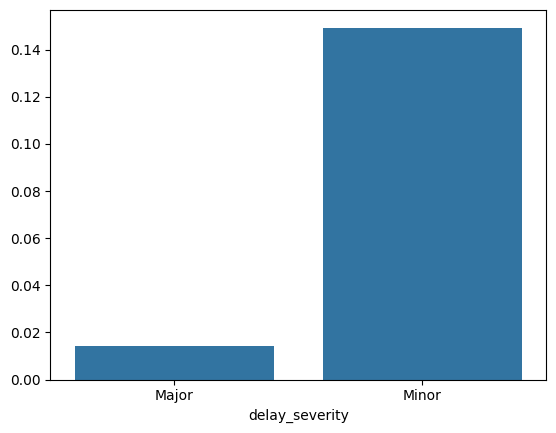

In [102]:
res = unique_trips.groupby('delay_severity').size() / total_trips
sns.barplot(res)

In [103]:
unique_trips['delay_severity'].fillna('On Time', inplace=True)

# Calculate percentage of delays by severity
delay_severity_counts = unique_trips['delay_severity'].value_counts(normalize=True) * 100
delay_severity_counts = delay_severity_counts.reset_index()
delay_severity_counts.columns = ['delay_severity', 'percentage']

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\2686362821.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\2686362821.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
# Create the bar plot using Plotly Express
fig = px.bar(delay_severity_counts, x='delay_severity', y='percentage', title="Percentage of Delayed Commutes by Severity",
             labels={'delay_severity': 'Delay Severity', 'percentage': 'Percentage'})
fig.show()

In [105]:
df3=unique_trips.copy()
df3.loc[df3.delay_minutes < 0,'delay_minutes'] =0

In [106]:
# day of week

In [107]:
# weekday vs weekend

In [108]:
def categorize_commute_time(timestamp):
    # Check if the day is a weekday (Monday=0, Sunday=6)
    if timestamp.weekday() >= 5:  # Saturday (5) and Sunday (6)
        return 'Weekend'
    
    morning_start = time(6, 0)
    morning_end = time(9, 0)
    evening_start = time(15, 30)
    evening_end = time(19, 30)
    
    commute_time = timestamp.time()
    
    if morning_start <= commute_time <= morning_end:
        return 'Morning'
    elif evening_start <= commute_time <= evening_end:
        return 'Evening'
    else:
        return 'Other'
unique_trips['commute_period'] =unique_trips['actual_arrival_time'].apply(categorize_commute_time)

# Filter for Morning and Evening commutes
filtered_trips = unique_trips[unique_trips['commute_period'].isin(['Morning', 'Evening'])]

# Calculate total trips for each commute period
total_commute_period_trips = filtered_trips.groupby('commute_period').size().reset_index(name='total_counts')

# Calculate counts of delays by commute period and severity
commute_delay_counts = filtered_trips.groupby(['commute_period', 'delay_severity']).size().reset_index(name='counts')

# Merge to get total counts for each commute period
commute_delay_counts = pd.merge(commute_delay_counts, total_commute_period_trips, on='commute_period')

# Calculate percentage of delays by commute period and severity
commute_delay_counts['percentage'] = (commute_delay_counts['counts'] / commute_delay_counts['total_counts']) * 100


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\3155030901.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
filtered_trips.groupby(['commute_period', 'delay_severity']).size().reset_index(name='counts')

,commute_period,delay_severity,counts
0,Evening,Major,29
1,Evening,Minor,442
2,Evening,On Time,1578
3,Morning,Major,31
4,Morning,Minor,138
5,Morning,On Time,1197


In [110]:
commute_delay_counts

,commute_period,delay_severity,counts,total_counts,percentage
0,Evening,Major,29,2049,1.415325
1,Evening,Minor,442,2049,21.571498
2,Evening,On Time,1578,2049,77.013177
3,Morning,Major,31,1366,2.269400
4,Morning,Minor,138,1366,10.102489
5,Morning,On Time,1197,1366,87.628111


In [111]:
# morning, evening commutes 6-9a / 3:30-7:30p
unique_trips.loc[(unique_trips.date == datetime(2024, 7, 16).date()) & (unique_trips.trip_id==306)].head(50)

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
39631,306,70012,2024-07-16,2024-07-16 08:26:04,San Francisco Caltrain Station Southbound,san_francisco,08:25:00,1.066667,False,On Time,Morning
39712,306,70022,2024-07-16,2024-07-16 08:39:05,22nd Street Caltrain Station Southbound,22nd_street,08:30:00,9.083333,True,Minor,Morning
39762,306,70042,2024-07-16,2024-07-16 08:48:06,South San Francisco Caltrain Station Southbound,south_sf,08:40:00,8.100000,True,Minor,Morning
39796,306,70062,2024-07-16,2024-07-16 08:54:07,Millbrae Caltrain Station Southbound,place_MLBR,08:46:00,8.116667,True,Minor,Morning
39836,306,70112,2024-07-16,2024-07-16 09:01:10,Hillsdale Caltrain Station Southbound,hillsdale,08:55:00,6.166667,True,Minor,Other
39860,306,70122,2024-07-16,2024-07-16 09:07:10,Belmont Caltrain Station Southbound,belmont,08:59:00,8.166667,True,Minor,Other
39884,306,70142,2024-07-16,2024-07-16 09:12:11,Redwood City Caltrain Station Southbound,redwood_city,09:05:00,7.183333,True,Minor,Other
39912,306,70162,2024-07-16,2024-07-16 09:19:12,Menlo Park Caltrain Station Southbound,menlo_park,09:10:00,9.200000,True,Minor,Other
39929,306,70172,2024-07-16,2024-07-16 09:22:12,Palo Alto Caltrain Station Southbound,palo_alto,09:14:00,8.200000,True,Minor,Other
39942,306,70192,2024-07-16,2024-07-16 09:25:12,California Avenue Caltrain Station Southbound,california_ave,09:18:00,7.200000,True,Minor,Other


In [112]:
# morning, evening commutes 6-9a / 3:30-7:30p
unique_trips.sort_values(by='actual_arrival_time').tail(50)

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
18666,130,70062,2024-07-16,2024-07-16 19:08:36,Millbrae Caltrain Station Southbound,place_MLBR,19:06:00,2.600000,False,On Time,Evening
23180,136,70162,2024-07-16,2024-07-16 19:08:36,Menlo Park Caltrain Station Southbound,menlo_park,21:51:00,0.000000,False,On Time,Evening
23909,137,70271,2024-07-16,2024-07-16 19:09:37,Tamien Caltrain Station Northbound,tamien,20:36:00,-86.383333,False,On Time,Evening
51419,415,70171,2024-07-16,2024-07-16 19:09:37,Palo Alto Caltrain Station Northbound,palo_alto,19:09:00,0.616667,False,On Time,Evening
17584,128,70242,2024-07-16,2024-07-16 19:09:37,Santa Clara Caltrain Station Southbound,santa_clara,19:09:00,0.616667,False,On Time,Evening
19536,131,70221,2024-07-16,2024-07-16 19:10:36,Sunnyvale Caltrain Station Northbound,sunnyvale,19:10:00,0.600000,False,On Time,Evening
17765,129,70061,2024-07-16,2024-07-16 19:10:36,Millbrae Caltrain Station Northbound,place_MLBR,19:04:00,6.600000,True,Minor,Evening
43226,313,70111,2024-07-16,2024-07-16 19:11:36,Hillsdale Caltrain Station Northbound,hillsdale,19:11:00,0.600000,False,On Time,Evening
59321,515,70241,2024-07-16,2024-07-16 19:12:36,Santa Clara Caltrain Station Northbound,santa_clara,19:47:00,-34.400000,False,On Time,Evening
51139,414,70222,2024-07-16,2024-07-16 19:12:36,Sunnyvale Caltrain Station Southbound,sunnyvale,19:12:00,0.600000,False,On Time,Evening


In [113]:
fig = px.histogram(unique_trips.loc[unique_trips.delay_minutes >=5],x='delay_minutes', color="commute_period",barmode='overlay')
fig.show()

In [114]:
unique_trips.date.unique()

array([datetime.date(2024, 7, 8), datetime.date(2024, 7, 10),
       datetime.date(2024, 7, 12), datetime.date(2024, 7, 15),
       datetime.date(2024, 7, 16), datetime.date(2024, 7, 9),
       datetime.date(2024, 7, 11), datetime.date(2024, 7, 13),
       datetime.date(2024, 7, 14), datetime.date(2024, 7, 7)],
      dtype=object)

In [115]:
unique_trips.parent_station.unique()

array(['22nd_street', 'bayshore', 'south_sf', 'san_bruno', 'place_MLBR',
       'burlingame', 'san_mateo', 'hayward_park', 'hillsdale', 'belmont',
       'san_carlos', 'redwood_city', 'menlo_park', 'palo_alto',
       'california_ave', 'san_antonio', 'mountain_view', 'sunnyvale',
       'lawrence', 'santa_clara', 'sj_diridon', 'tamien', 'san_francisco',
       'college_park', 'broadway', 'capitol', 'blossom_hill',
       'morgan_hill', 'san_martin', 'gilroy'], dtype=object)

In [116]:
def clean_station_name(name):
    if name == 'place_MLBR':
        return 'Millbrae'
    name = name.replace('_', ' ')
    return name.title()
# Apply the cleaning function to parent_station names
unique_trips['parent_station'] = unique_trips['parent_station'].apply(clean_station_name)


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_1968\832418268.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
(comparison_df['delay_minutes'] > 4) & (comparison_df['delay_minutes'] < 500)

0        False
1        False
2        False
3        False
4        False
         ...  
65931    False
65932    False
65933    False
65934    False
65935    False
Name: delay_minutes, Length: 65936, dtype: bool

In [118]:
import plotly.graph_objects as go
# Create a pivot table for the heatmap
# Create a pivot table for the heatmap
unique_trips.loc[unique_trips.delay_minutes < 0,'delay_minutes']=0
heatmap_data = unique_trips.pivot_table(index='trip_id', columns='stop_id', values='delay_minutes', aggfunc='mean', sort=False)
stop_id_to_parent_station = unique_trips[['stop_id', 'parent_station']].drop_duplicates().set_index('stop_id')['parent_station'].to_dict()

# Sort the columns of the pivot table explicitly
heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
heatmap_data.columns = [stop_id_to_parent_station[stop_id] for stop_id in heatmap_data.columns]
heatmap_data.index=heatmap_data.index.astype(str)
# heatmap_data = heatmap_data.sort_index(axis=1)
# Create the heatmap using Plotly
fig_heatmap = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='Viridis',

))

fig_heatmap.update_layout(
    title="Heatmap of Delays by Stop and Train Number",
    xaxis_title="Stop",
    yaxis_title="Train Number",
    height = 1000,
)

In [119]:
h=heatmap_data.reset_index()

In [120]:
h.loc[h.trip_id=='309']

,trip_id,San Francisco,22Nd Street,22Nd Street,Bayshore,Bayshore,South Sf,South Sf,San Bruno,San Bruno,...,Tamien,Capitol,Capitol,Blossom Hill,Blossom Hill,Morgan Hill,Morgan Hill,San Martin,San Martin,Gilroy
81,309,NaN,7.554167,NaN,NaN,NaN,7.533333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
# scatter = go.Scatter(x=np.array(lon).flatten(),
#                      y=np.array(lat).flatten(),
#                      marker={'color': np.array(v).flatten(),
#                              'showscale': True},
#                      mode='markers')
# fig = go.FigureWidget(data=[scatter],
#                       layout={'xaxis': {'title': 'lon'},
#                               'yaxis': {'title': 'lat'}})
# fig

In [122]:
unique_trips.loc[unique_trips.trip_id==309]

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
41075,309,70021,2024-07-10,2024-07-10 17:53:25,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,18.416667,True,Major,Evening
41084,309,70021,2024-07-12,2024-07-12 17:40:32,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,5.533333,True,Minor,Evening
41093,309,70021,2024-07-15,2024-07-15 17:36:05,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,1.083333,False,On Time,Evening
41103,309,70021,2024-07-16,2024-07-16 17:40:11,22nd Street Caltrain Station Northbound,22Nd Street,17:35:00,5.183333,True,Minor,Evening
41111,309,70041,2024-07-10,2024-07-10 17:44:24,South San Francisco Caltrain Station Northbound,South Sf,17:26:00,18.400000,True,Major,Evening
41118,309,70041,2024-07-12,2024-07-12 17:31:30,South San Francisco Caltrain Station Northbound,South Sf,17:26:00,5.500000,True,Minor,Evening
41125,309,70041,2024-07-15,2024-07-15 17:26:04,South San Francisco Caltrain Station Northbound,South Sf,17:26:00,0.066667,False,On Time,Evening
41132,309,70041,2024-07-16,2024-07-16 17:32:10,South San Francisco Caltrain Station Northbound,South Sf,17:26:00,6.166667,True,Minor,Evening
41139,309,70061,2024-07-10,2024-07-10 17:36:07,Millbrae Caltrain Station Northbound,Millbrae,17:19:00,17.116667,True,Major,Evening
41152,309,70061,2024-07-12,2024-07-12 17:24:29,Millbrae Caltrain Station Northbound,Millbrae,17:19:00,5.483333,True,Minor,Evening


In [123]:
# Calculate percentage of delays by severity
daily_summary = unique_trips.groupby('date')['delay_severity'].value_counts(normalize=True).unstack() * 100

# # Reset index to have date as a column
daily_summary = daily_summary.reset_index()
# # Melt the DataFrame for Plotly
daily_summary_melted = daily_summary.melt(id_vars='date', value_vars=['Major',	'Minor','On Time'], var_name='Status', value_name='Percentage')
import plotly.express as px

# Create the stacked bar plot
fig = px.bar(daily_summary_melted, x='date', y='Percentage', color='Status', title='Percentage of On Time and Delayed Trips per Day')

# Show the plot
fig.show()


In [124]:
daily_summary_melted

,date,Status,Percentage
0,2024-07-07,Major,NaN
1,2024-07-08,Major,4.215976
2,2024-07-09,Major,NaN
3,2024-07-10,Major,2.620456
4,2024-07-11,Major,NaN
5,2024-07-12,Major,1.256467
6,2024-07-13,Major,NaN
7,2024-07-14,Major,NaN
8,2024-07-15,Major,0.832702
9,2024-07-16,Major,0.539568


In [125]:
import pandas as pd
import plotly.express as px

# Calculate percentage of delays by severity
daily_summary = unique_trips.groupby('date')['delay_severity'].value_counts(normalize=True).unstack() * 100

# Reset index to have date as a column
daily_summary = daily_summary.reset_index()

# Melt the DataFrame for Plotly
daily_summary_melted = daily_summary.melt(id_vars='date', value_vars=['Major', 'Minor', 'On Time'], var_name='Status', value_name='Percentage')

# Define the order of the Status items
status_order = ['On Time', 'Minor Delay', 'Major Delay']
daily_summary_melted.loc[daily_summary_melted.Status == 'Major','Status']='Major Delay'
daily_summary_melted.loc[daily_summary_melted.Status == 'Minor','Status']='Minor Delay'
# Define custom colors for each Status
status_colors = {
    'On Time': '#00CC96',
    'Minor Delay': '#FECB52',
    'Major Delay': '#EF553B'
}

# Create the stacked bar plot
fig = px.bar(daily_summary_melted, x='date', y='Percentage', color='Status', 
             title='On-time performance by date',
             category_orders={'Status': status_order},
             color_discrete_map=status_colors,labels={'date': 'Date', 'percentage': 'Percentage','Minor':'Minor Delay'})

# Show the plot
fig.show()

